# FEEDBACK CONTROL EXAMPLE

This notebook explores feedback control for the glycolytic oscillations model of Jenna Wolf.

# Preliminaries

In [1]:
from controlSBML.control_extensions.state_space_tf import StateSpaceTF
import controlSBML as ctl

import control
import numpy as np
import pandas as pd
import sympy
import tellurium as te
import matplotlib.pyplot as plt

In [2]:
TIMES = [0.1*v for v in range(51)]

In [3]:
CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml",
                       input_names=["at"])

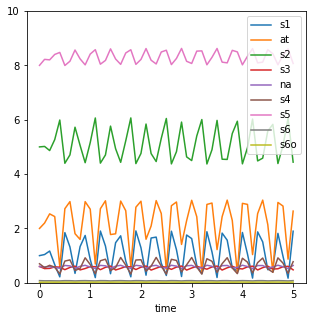

In [4]:
CTLSB.plotTrueModel(ylim=[0, 10], figsize=(5,5))

In [5]:
# at: ATP
# na: NAD+
# s4: 3-Phospho-D-glycerate
# s5: pyruvic acid
print(CTLSB.antimony)

// Created by libAntimony v2.12.0
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

# Controller Construction

## Reaction Network

    v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
    v2: s2 -> 2 s3; compartment_*k2*s2;
    v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) 
                             - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
    v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
    v5: s5 -> s6; compartment_*k5*s5;
    v7: at_ -> ; compartment_*k7*at_;
    v8: s3 -> na; compartment_*k8*s3*(ntot - na);
    v9: s6o -> ; compartment_*k9*s6o;
    v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
    v6: s6 -> na; compartment_*k6*s6*(ntot - na);
    v0:  -> s1; compartment_*k0;

## Regulating Pyruvate (``s5``)

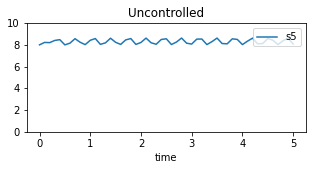

In [17]:
URL_206 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"
CTLSB = ctl.ControlSBML(URL_206, input_names=["at"], output_names=["s5"])
CTLSB.plotTrueModel(names=["s5"], ylim=[0, 10], title="Uncontrolled", figsize=(5,2))

In [7]:
CTLSB = ctl.ControlSBML(URL_206, input_names=["at"], output_names=["s5"])
sys = CTLSB.makeNonlinearIOSystem("sys")

In [8]:
ref = [6]  # Desired value of pyruvate
def outfcn(t, x, u, _):
    return 0.01*(ref - u)
controller = control.NonlinearIOSystem(
  None,
  outfcn,
  inputs=['in'],
  outputs=['out'], name='controller')

In [12]:
# Create the closed loop system
closed = control.interconnect(
  [sys, controller],       # systems
  connections=[
    ['sys.at', 'controller.out'],
    ['controller.in',  'sys.s5'],
  ],
  inplist=["controller.in"],
  outlist=["sys.s5"],
)

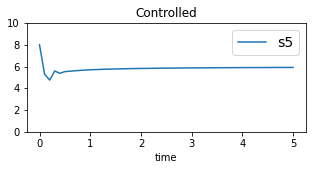

In [20]:
times = TIMES
result = control.input_output_response(closed, times, X0=ctl.makeStateVector(closed))

ser = ctl.mat2DF(result.outputs, row_names=times)
_, ax = plt.subplots(1, figsize=(5,2))
ax.plot(ser.index, ser.values)
ax.set_ylim([0, 10])
ax.set_xlabel("time")
_ = ax.set_title("Controlled")
ax.legend(["s5"], fontsize=14)